#1. Installing Required Dependencies

In [ ]:
# Install dependencies
!pip install torch torchvision transformers datasets scikit-learn seaborn matplotlib kagglehub tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


#2. Import all the required libraries

In [ ]:
import os
import shutil
import random
import numpy as np
from functools import partial
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
from transformers import AutoImageProcessor, ViTModel, ViTHybridModel, ViTHybridImageProcessor, ViTHybridForImageClassification
from datasets import load_dataset, Image
from datasets import Features, ClassLabel, Value, Array3D
import torchvision.transforms as T
from tqdm.auto import tqdm
import kagglehub

#3. Download and Load the Weather Dataset

In [ ]:
path = kagglehub.dataset_download("jehanbhathena/weather-dataset")
print("Path to dataset files:", path)
dataset_path = path
dataset = load_dataset("imagefolder", data_dir=dataset_path)
print("Dataset:", dataset)
print("Classes:", dataset["train"].features["label"].names)

100%|██████████| 587M/587M [00:27<00:00, 22.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3


Resolving data files:   0%|          | 0/6862 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6862
    })
})
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


#4. Split dataset into Train/Validation/Test

In [ ]:
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
test_dataset = dataset["test"]
train_val_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = train_val_dataset["train"]
val_dataset = train_val_dataset["test"]

class_names = train_dataset.features["label"].names
num_classes = len(class_names)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))
print("Number of classes:", num_classes)

Train size: 4391
Val size: 1098
Test size: 1373
Number of classes: 11


#5. Set Device for Computation (CPU or GPU)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


#6. Handling Class Imbalance with WeightedRandomSampler

In [ ]:
train_labels = [ex["label"] for ex in train_dataset]
class_counts = Counter(train_labels)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
weights = [class_weights[l] for l in train_labels]

sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

#7. Mixup Data Augmentation for Training

In [ ]:
use_mixup = True
mixup_alpha = 0.4

def mixup_data(x, y, alpha=0.4):
    if alpha <= 0:
        return x, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

#8. Custom Collate Function for DataLoader

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([ex["pixel_values"].squeeze() for ex in examples])
    labels = torch.tensor([ex["label"] for ex in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# 9. Image Augmentations for Training and Validation

In [ ]:
train_augmentation_vit = T.Compose([
    T.Lambda(lambda img: img.convert("RGB")),
    T.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
])

val_test_augmentation_vit = T.Compose([
    T.Lambda(lambda img: img.convert("RGB")),
    T.Resize((224, 224))
])

train_augmentation_hybrid = T.Compose([
    T.Lambda(lambda img: img.convert("RGB")),
    T.RandomResizedCrop((384, 384), scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
])

val_test_augmentation_hybrid = T.Compose([
    T.Lambda(lambda img: img.convert("RGB")),
    T.Resize((384, 384))
])

# 10. Generate Transformation Functions for Dataset Preprocessing

In [ ]:
def get_transform_fns(augmentation_fn, image_processor):
    def transform_fn(examples):
        images = [augmentation_fn(img) for img in examples["image"]]
        inputs = image_processor(images, return_tensors="pt")
        examples["pixel_values"] = inputs["pixel_values"]
        return examples
    return transform_fn

#11. Evaluate Model Performance on the Dataset

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for batch in loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            logits, _ = model(pixel_values, labels=None)
            preds = torch.argmax(logits, dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            preds_all.extend(preds.cpu().tolist())
            labels_all.extend(labels.cpu().tolist())

    acc = correct / total
    return acc, preds_all, labels_all

#12. Visualization Functions for Training and Evaluation

In [ ]:
def plot_curves(history, title_prefix="Model"):
    train_loss, train_acc, val_loss, val_acc = history
    epochs = range(1, len(train_loss)+1)

    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, 'r-', label='Train Loss')
    plt.plot(epochs, val_loss, 'b-', label='Val Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, 'r-', label='Train Acc')
    plt.plot(epochs, val_acc, 'b-', label='Val Acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(labels, preds, class_names, title_prefix=""):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{title_prefix} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_per_class_accuracy(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(8,6))
    plt.barh(class_names, per_class_acc, color='skyblue')
    plt.xlabel("Accuracy")
    plt.title("Per-Class Accuracy")
    for i, v in enumerate(per_class_acc):
        plt.text(v + 0.01, i, f"{v:.2f}", va='center')
    plt.show()

def show_predictions(model, loader, num_images=8, image_processor=None, class_names=None):
    model.eval()
    batch = next(iter(loader))
    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        logits, _ = model(pixel_values)
        preds = torch.argmax(logits, dim=-1)

    pixel_values = pixel_values.cpu()
    mean = np.array(image_processor.image_mean)
    std = np.array(image_processor.image_std)

    plt.figure(figsize=(16,8))
    for i in range(min(num_images, pixel_values.size(0))):
        img = pixel_values[i].permute(1,2,0).numpy()
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis('off')
    plt.show()

#13. Custom Vision Transformer Model Training

In [ ]:
class ViTForWeatherClassification(nn.Module):
    def __init__(self, base_model, num_classes, class_weights=None):
        super().__init__()
        self.base_model = base_model
        self.classifier = nn.Linear(self.base_model.config.hidden_size, num_classes)
        self.class_weights = class_weights

    def forward(self, pixel_values, labels=None, mixup=False, mixup_alpha=0.4):
        outputs = self.base_model(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.class_weights is not None and not mixup:
                weight_tensor = self.class_weights.to(logits.device)
                loss_fct = nn.CrossEntropyLoss(weight=weight_tensor)
                loss = loss_fct(logits, labels)
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits, labels)

        return logits, loss

def train_model(model, train_loader, val_loader, epochs=50, lr=2e-5, use_mixup=True, mixup_alpha=0.4):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    best_acc = 0.0
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch in train_bar:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()

            if use_mixup:
                pixel_values, y_a, y_b, lam = mixup_data(pixel_values, labels, alpha=mixup_alpha)
                logits, _ = model(pixel_values, labels=None)
                loss_fct = nn.CrossEntropyLoss()
                loss = mixup_criterion(loss_fct, logits, y_a, y_b, lam)
                preds = torch.argmax(logits, dim=-1)
            else:
                logits, loss = model(pixel_values, labels)
                preds = torch.argmax(logits, dim=-1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * pixel_values.size(0)
            if use_mixup:
                correct += (preds == y_a).sum().item()
            else:
                correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)
                logits, loss = model(pixel_values, labels)
                val_loss += loss.item() * pixel_values.size(0)
                preds = torch.argmax(logits, dim=-1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_loss / total_val
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_weights = model.state_dict()

    model.load_state_dict(best_model_weights)
    print("Best Val Acc:", best_acc)
    return model, (train_losses, train_accuracies, val_losses, val_accuracies)

# 14. Convert class_weights dict to a list for loss weighting

In [ ]:
class_weights_tensor = []
for i in range(num_classes):
    class_weights_tensor.append(1.0 / class_counts[i])
class_weights_tensor = torch.tensor(class_weights_tensor, dtype=torch.float32)

# 15. Hyperparameters for tuning

In [ ]:
EPOCHS = 50
LEARNING_RATE = 2e-5
BATCH_SIZE = 32
USE_MIXUP = True
MIXUP_ALPHA = 0.4

#16. Train and evaluate ViT model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Training ViT Model:


Epoch 1/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 1.6596, Acc: 0.3667 | Val Loss: 0.7147, Acc: 0.8752


Epoch 2/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 0.9131, Acc: 0.5140 | Val Loss: 0.3808, Acc: 0.9153


Epoch 3/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 0.8111, Acc: 0.5249 | Val Loss: 0.3351, Acc: 0.9199


Epoch 4/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 0.7326, Acc: 0.5511 | Val Loss: 0.2857, Acc: 0.9290


Epoch 5/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 0.7435, Acc: 0.5181 | Val Loss: 0.2857, Acc: 0.9171


Epoch 6/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 0.6895, Acc: 0.4908 | Val Loss: 0.2394, Acc: 0.9435


Epoch 7/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 0.6946, Acc: 0.5448 | Val Loss: 0.2451, Acc: 0.9372


Epoch 8/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 0.6507, Acc: 0.5243 | Val Loss: 0.2343, Acc: 0.9417


Epoch 9/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 0.6668, Acc: 0.5734 | Val Loss: 0.2289, Acc: 0.9481


Epoch 10/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 0.6462, Acc: 0.4869 | Val Loss: 0.2210, Acc: 0.9472


Epoch 11/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 11/50 - Train Loss: 0.5717, Acc: 0.5621 | Val Loss: 0.2306, Acc: 0.9362


Epoch 12/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 12/50 - Train Loss: 0.5818, Acc: 0.5739 | Val Loss: 0.2033, Acc: 0.9472


Epoch 13/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 13/50 - Train Loss: 0.5796, Acc: 0.5475 | Val Loss: 0.2078, Acc: 0.9463


Epoch 14/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 14/50 - Train Loss: 0.5961, Acc: 0.5233 | Val Loss: 0.2206, Acc: 0.9435


Epoch 15/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 15/50 - Train Loss: 0.5227, Acc: 0.5930 | Val Loss: 0.2127, Acc: 0.9490


Epoch 16/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 16/50 - Train Loss: 0.5464, Acc: 0.5108 | Val Loss: 0.2186, Acc: 0.9435


Epoch 17/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 17/50 - Train Loss: 0.6391, Acc: 0.5179 | Val Loss: 0.2142, Acc: 0.9435


Epoch 18/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 18/50 - Train Loss: 0.5809, Acc: 0.5935 | Val Loss: 0.2103, Acc: 0.9444


Epoch 19/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 19/50 - Train Loss: 0.5423, Acc: 0.4824 | Val Loss: 0.2494, Acc: 0.9362


Epoch 20/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 20/50 - Train Loss: 0.5393, Acc: 0.5514 | Val Loss: 0.2283, Acc: 0.9353


Epoch 21/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 21/50 - Train Loss: 0.5540, Acc: 0.5174 | Val Loss: 0.2230, Acc: 0.9362


Epoch 22/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 22/50 - Train Loss: 0.5467, Acc: 0.5443 | Val Loss: 0.2134, Acc: 0.9417


Epoch 23/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 23/50 - Train Loss: 0.5279, Acc: 0.5468 | Val Loss: 0.2276, Acc: 0.9435


Epoch 24/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 24/50 - Train Loss: 0.5236, Acc: 0.5167 | Val Loss: 0.2074, Acc: 0.9463


Epoch 25/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 25/50 - Train Loss: 0.5312, Acc: 0.5657 | Val Loss: 0.2325, Acc: 0.9372


Epoch 26/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 26/50 - Train Loss: 0.5303, Acc: 0.5270 | Val Loss: 0.2114, Acc: 0.9463


Epoch 27/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 27/50 - Train Loss: 0.4929, Acc: 0.6124 | Val Loss: 0.2268, Acc: 0.9426


Epoch 28/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 28/50 - Train Loss: 0.5302, Acc: 0.5577 | Val Loss: 0.2353, Acc: 0.9426


Epoch 29/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 29/50 - Train Loss: 0.4651, Acc: 0.5366 | Val Loss: 0.2235, Acc: 0.9408


Epoch 30/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 30/50 - Train Loss: 0.6018, Acc: 0.5525 | Val Loss: 0.2152, Acc: 0.9426


Epoch 31/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 31/50 - Train Loss: 0.4848, Acc: 0.5873 | Val Loss: 0.2269, Acc: 0.9362


Epoch 32/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 32/50 - Train Loss: 0.5154, Acc: 0.5477 | Val Loss: 0.2235, Acc: 0.9372


Epoch 33/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 33/50 - Train Loss: 0.5244, Acc: 0.5689 | Val Loss: 0.2306, Acc: 0.9408


Epoch 34/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 34/50 - Train Loss: 0.5372, Acc: 0.4912 | Val Loss: 0.2230, Acc: 0.9417


Epoch 35/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 35/50 - Train Loss: 0.5255, Acc: 0.6037 | Val Loss: 0.2429, Acc: 0.9362


Epoch 36/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 36/50 - Train Loss: 0.5206, Acc: 0.5459 | Val Loss: 0.2325, Acc: 0.9408


Epoch 37/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 37/50 - Train Loss: 0.4871, Acc: 0.5375 | Val Loss: 0.2191, Acc: 0.9381


Epoch 38/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 38/50 - Train Loss: 0.5598, Acc: 0.5031 | Val Loss: 0.2198, Acc: 0.9399


Epoch 39/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 39/50 - Train Loss: 0.5716, Acc: 0.5616 | Val Loss: 0.2179, Acc: 0.9399


Epoch 40/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 40/50 - Train Loss: 0.4974, Acc: 0.5618 | Val Loss: 0.2277, Acc: 0.9353


Epoch 41/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 41/50 - Train Loss: 0.4603, Acc: 0.6267 | Val Loss: 0.2262, Acc: 0.9390


Epoch 42/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 42/50 - Train Loss: 0.5086, Acc: 0.5696 | Val Loss: 0.2490, Acc: 0.9326


Epoch 43/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 43/50 - Train Loss: 0.4917, Acc: 0.5411 | Val Loss: 0.2340, Acc: 0.9435


Epoch 44/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 44/50 - Train Loss: 0.4887, Acc: 0.5584 | Val Loss: 0.2420, Acc: 0.9353


Epoch 45/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 45/50 - Train Loss: 0.4797, Acc: 0.5017 | Val Loss: 0.2285, Acc: 0.9417


Epoch 46/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 46/50 - Train Loss: 0.4696, Acc: 0.5015 | Val Loss: 0.2492, Acc: 0.9381


Epoch 47/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 47/50 - Train Loss: 0.4723, Acc: 0.6331 | Val Loss: 0.2265, Acc: 0.9399


Epoch 48/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 48/50 - Train Loss: 0.4928, Acc: 0.4837 | Val Loss: 0.2309, Acc: 0.9435


Epoch 49/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 49/50 - Train Loss: 0.4850, Acc: 0.5482 | Val Loss: 0.2306, Acc: 0.9390


Epoch 50/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 50/50 - Train Loss: 0.4537, Acc: 0.5666 | Val Loss: 0.2281, Acc: 0.9435
Best Val Acc: 0.9489981785063752


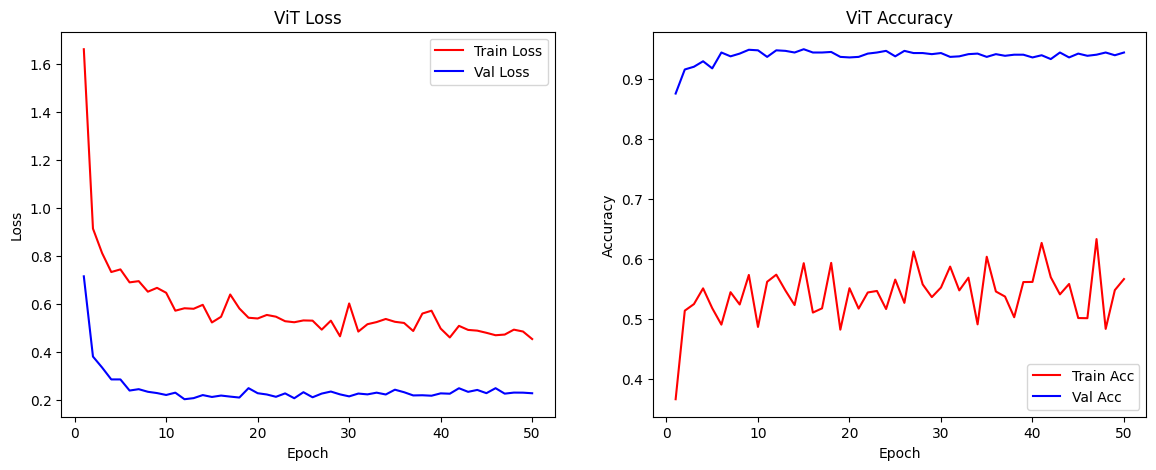


Evaluating ViT on Test Set:
Test Accuracy: 0.9359
              precision    recall  f1-score   support

         dew       0.99      0.98      0.99       125
     fogsmog       0.92      0.97      0.95       180
       frost       0.84      0.91      0.88        92
       glaze       0.88      0.90      0.89       136
        hail       0.98      0.99      0.99       119
   lightning       0.98      1.00      0.99        60
        rain       0.99      0.88      0.93       102
     rainbow       1.00      1.00      1.00        47
        rime       0.92      0.90      0.91       244
   sandstorm       0.95      0.93      0.94       127
        snow       0.92      0.90      0.91       141

    accuracy                           0.94      1373
   macro avg       0.94      0.94      0.94      1373
weighted avg       0.94      0.94      0.94      1373

ViT Macro-F1: 0.9432, Micro-F1: 0.9359


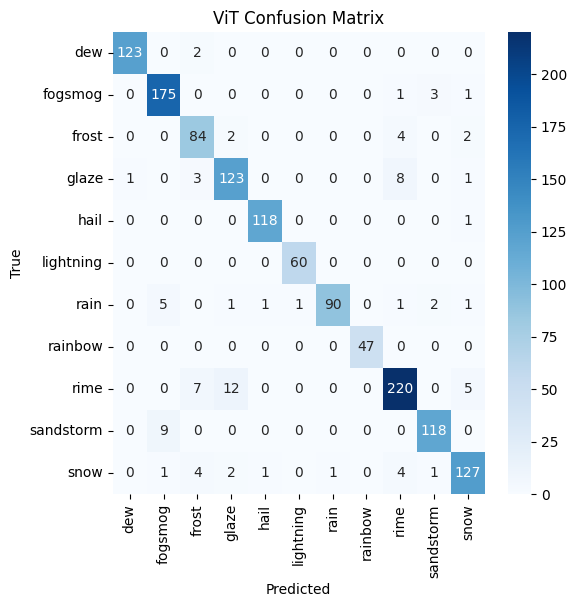

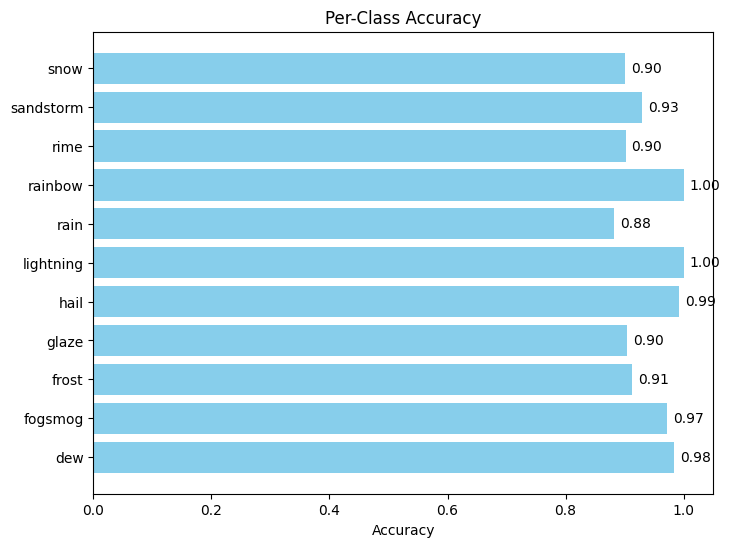

Visual Predictions from ViT:


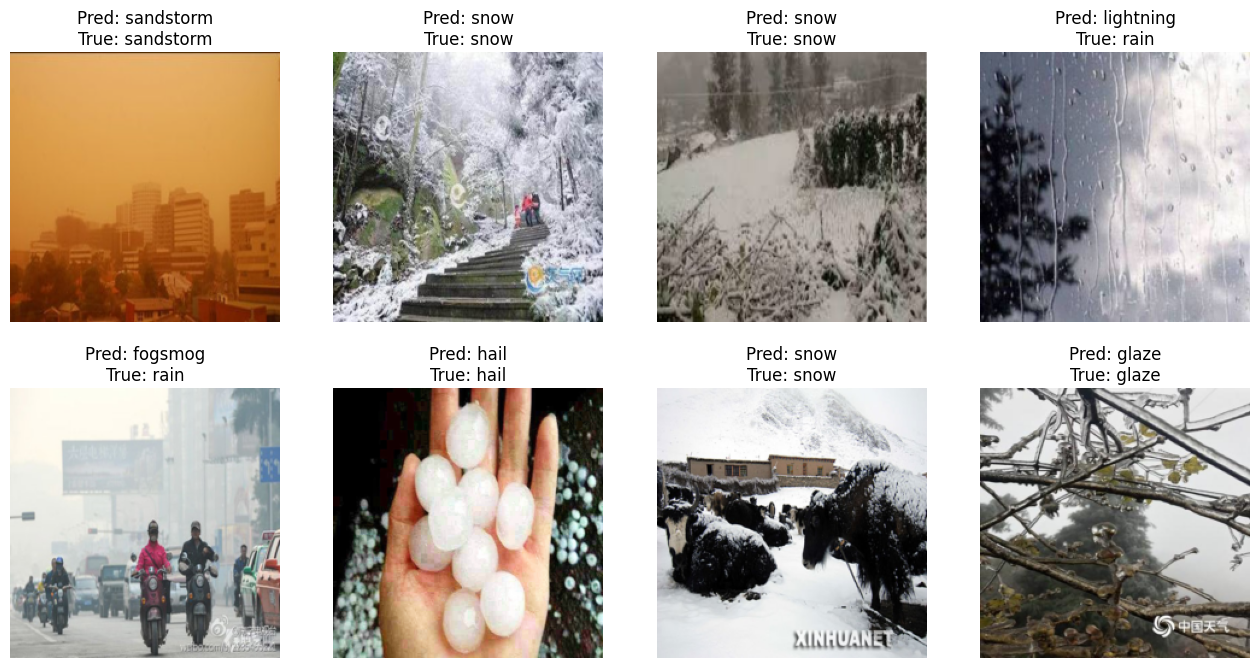

In [ ]:
image_processor_vit = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k", use_fast=True)
train_dataset_vit = train_dataset.with_transform(get_transform_fns(train_augmentation_vit, image_processor_vit))
val_dataset_vit = val_dataset.with_transform(get_transform_fns(val_test_augmentation_vit, image_processor_vit))
test_dataset_vit = test_dataset.with_transform(get_transform_fns(val_test_augmentation_vit, image_processor_vit))

train_loader_vit = DataLoader(train_dataset_vit, batch_size=BATCH_SIZE, sampler=sampler, collate_fn=collate_fn)
val_loader_vit = DataLoader(val_dataset_vit, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader_vit = DataLoader(test_dataset_vit, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

vit_base = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTForWeatherClassification(vit_base, num_classes=num_classes, class_weights=class_weights_tensor)

print("\nTraining ViT Model:")
vit_trained, vit_history = train_model(vit_model, train_loader_vit, val_loader_vit,
                                       epochs=EPOCHS, lr=LEARNING_RATE,
                                       use_mixup=USE_MIXUP, mixup_alpha=MIXUP_ALPHA)
plot_curves(vit_history, title_prefix="ViT")

print("\nEvaluating ViT on Test Set:")
vit_acc, vit_preds, vit_labels = evaluate(vit_trained, test_loader_vit)
print(f"Test Accuracy: {vit_acc:.4f}")
print(classification_report(vit_labels, vit_preds, target_names=class_names))
f1_macro = f1_score(vit_labels, vit_preds, average='macro')
f1_micro = f1_score(vit_labels, vit_preds, average='micro')
print(f"ViT Macro-F1: {f1_macro:.4f}, Micro-F1: {f1_micro:.4f}")
plot_confusion_matrix(vit_labels, vit_preds, class_names, "ViT")
plot_per_class_accuracy(vit_labels, vit_preds, class_names)
print("Visual Predictions from ViT:")
show_predictions(vit_trained, test_loader_vit, num_images=8, image_processor=image_processor_vit, class_names=class_names)

#17. Train and evaluate ViT-Hybrid model

preprocessor_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/71.9k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/396M [00:00<?, ?B/s]

Some weights of ViTHybridModel were not initialized from the model checkpoint at google/vit-hybrid-base-bit-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training ViT-Hybrid Model:


Epoch 1/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 1.0611, Acc: 0.5092 | Val Loss: 0.2861, Acc: 0.9253


Epoch 2/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 0.7344, Acc: 0.4787 | Val Loss: 0.2440, Acc: 0.9317


Epoch 3/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 0.6517, Acc: 0.5520 | Val Loss: 0.2047, Acc: 0.9408


Epoch 4/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 0.6796, Acc: 0.5427 | Val Loss: 0.2313, Acc: 0.9353


Epoch 5/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 0.5760, Acc: 0.5639 | Val Loss: 0.1949, Acc: 0.9435


Epoch 6/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 0.5577, Acc: 0.5304 | Val Loss: 0.1908, Acc: 0.9490


Epoch 7/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 0.5787, Acc: 0.5887 | Val Loss: 0.1794, Acc: 0.9481


Epoch 8/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 0.5613, Acc: 0.5919 | Val Loss: 0.2175, Acc: 0.9435


Epoch 9/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 0.5255, Acc: 0.5514 | Val Loss: 0.2050, Acc: 0.9353


Epoch 10/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 0.5987, Acc: 0.5338 | Val Loss: 0.1833, Acc: 0.9444


Epoch 11/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 11/50 - Train Loss: 0.5150, Acc: 0.5623 | Val Loss: 0.1787, Acc: 0.9472


Epoch 12/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 12/50 - Train Loss: 0.4993, Acc: 0.5737 | Val Loss: 0.1749, Acc: 0.9481


Epoch 13/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 13/50 - Train Loss: 0.4892, Acc: 0.5687 | Val Loss: 0.1899, Acc: 0.9490


Epoch 14/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 14/50 - Train Loss: 0.4892, Acc: 0.5830 | Val Loss: 0.1788, Acc: 0.9508


Epoch 15/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 15/50 - Train Loss: 0.4962, Acc: 0.5646 | Val Loss: 0.1976, Acc: 0.9463


Epoch 16/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 16/50 - Train Loss: 0.5323, Acc: 0.5466 | Val Loss: 0.1882, Acc: 0.9481


Epoch 17/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 17/50 - Train Loss: 0.5100, Acc: 0.5564 | Val Loss: 0.1786, Acc: 0.9463


Epoch 18/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 18/50 - Train Loss: 0.5214, Acc: 0.6345 | Val Loss: 0.1931, Acc: 0.9454


Epoch 19/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 19/50 - Train Loss: 0.5176, Acc: 0.5832 | Val Loss: 0.1932, Acc: 0.9472


Epoch 20/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 20/50 - Train Loss: 0.4552, Acc: 0.5172 | Val Loss: 0.1659, Acc: 0.9517


Epoch 21/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 21/50 - Train Loss: 0.4319, Acc: 0.5377 | Val Loss: 0.1511, Acc: 0.9517


Epoch 22/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 22/50 - Train Loss: 0.4441, Acc: 0.6128 | Val Loss: 0.1581, Acc: 0.9536


Epoch 23/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 23/50 - Train Loss: 0.4356, Acc: 0.5309 | Val Loss: 0.1693, Acc: 0.9545


Epoch 24/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 24/50 - Train Loss: 0.4405, Acc: 0.5901 | Val Loss: 0.1813, Acc: 0.9408


Epoch 25/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 25/50 - Train Loss: 0.4355, Acc: 0.5463 | Val Loss: 0.1726, Acc: 0.9463


Epoch 26/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 26/50 - Train Loss: 0.4501, Acc: 0.5905 | Val Loss: 0.2225, Acc: 0.9362


Epoch 27/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 27/50 - Train Loss: 0.4579, Acc: 0.5887 | Val Loss: 0.1792, Acc: 0.9517


Epoch 28/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 28/50 - Train Loss: 0.4186, Acc: 0.4723 | Val Loss: 0.1614, Acc: 0.9499


Epoch 29/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 29/50 - Train Loss: 0.4040, Acc: 0.5687 | Val Loss: 0.1651, Acc: 0.9517


Epoch 30/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 30/50 - Train Loss: 0.4714, Acc: 0.5573 | Val Loss: 0.1892, Acc: 0.9390


Epoch 31/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 31/50 - Train Loss: 0.4590, Acc: 0.5263 | Val Loss: 0.2092, Acc: 0.9344


Epoch 32/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 32/50 - Train Loss: 0.4846, Acc: 0.5668 | Val Loss: 0.1776, Acc: 0.9481


Epoch 33/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 33/50 - Train Loss: 0.4867, Acc: 0.5206 | Val Loss: 0.2030, Acc: 0.9426


Epoch 34/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 34/50 - Train Loss: 0.4751, Acc: 0.5564 | Val Loss: 0.2149, Acc: 0.9399


Epoch 35/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 35/50 - Train Loss: 0.4460, Acc: 0.5785 | Val Loss: 0.2113, Acc: 0.9426


Epoch 36/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 36/50 - Train Loss: 0.4376, Acc: 0.4757 | Val Loss: 0.1808, Acc: 0.9444


Epoch 37/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 37/50 - Train Loss: 0.3804, Acc: 0.5092 | Val Loss: 0.1956, Acc: 0.9481


Epoch 38/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 38/50 - Train Loss: 0.4505, Acc: 0.5534 | Val Loss: 0.1958, Acc: 0.9417


Epoch 39/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 39/50 - Train Loss: 0.4972, Acc: 0.5343 | Val Loss: 0.2205, Acc: 0.9417


Epoch 40/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 40/50 - Train Loss: 0.4478, Acc: 0.5712 | Val Loss: 0.2018, Acc: 0.9444


Epoch 41/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 41/50 - Train Loss: 0.4591, Acc: 0.5361 | Val Loss: 0.1965, Acc: 0.9426


Epoch 42/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 42/50 - Train Loss: 0.4303, Acc: 0.5001 | Val Loss: 0.1958, Acc: 0.9463


Epoch 43/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 43/50 - Train Loss: 0.4339, Acc: 0.5539 | Val Loss: 0.2177, Acc: 0.9399


Epoch 44/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 44/50 - Train Loss: 0.4591, Acc: 0.5623 | Val Loss: 0.1923, Acc: 0.9472


Epoch 45/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 45/50 - Train Loss: 0.4030, Acc: 0.5498 | Val Loss: 0.1727, Acc: 0.9472


Epoch 46/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 46/50 - Train Loss: 0.4200, Acc: 0.5361 | Val Loss: 0.1835, Acc: 0.9536


Epoch 47/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 47/50 - Train Loss: 0.4394, Acc: 0.5443 | Val Loss: 0.1973, Acc: 0.9454


Epoch 48/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 48/50 - Train Loss: 0.4010, Acc: 0.5498 | Val Loss: 0.2188, Acc: 0.9426


Epoch 49/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 49/50 - Train Loss: 0.4277, Acc: 0.6169 | Val Loss: 0.1806, Acc: 0.9454


Epoch 50/50:   0%|          | 0/138 [00:00<?, ?it/s]

Epoch 50/50 - Train Loss: 0.4555, Acc: 0.5919 | Val Loss: 0.2575, Acc: 0.9344
Best Val Acc: 0.9544626593806922


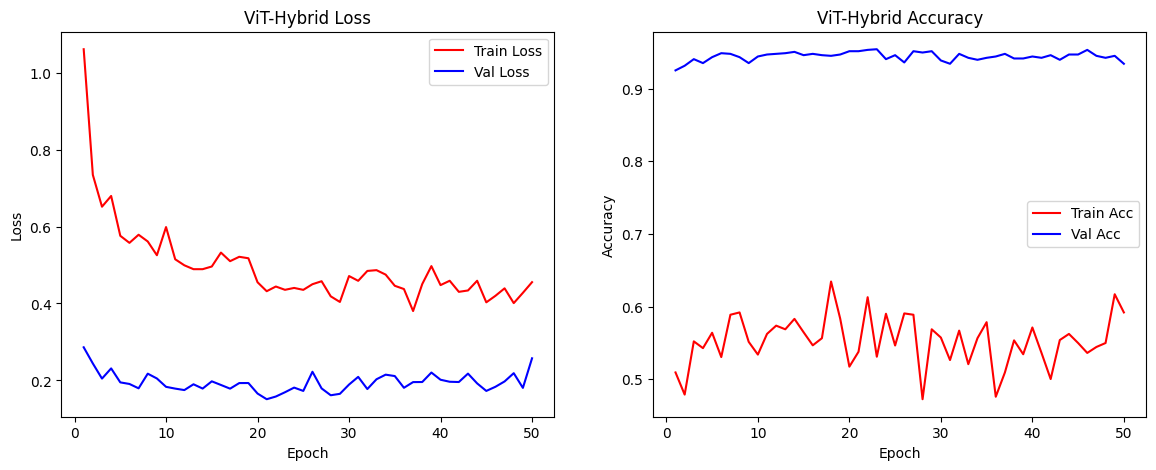


Evaluating ViT-Hybrid on Test Set:
Test Accuracy: 0.9432
              precision    recall  f1-score   support

         dew       1.00      0.98      0.99       125
     fogsmog       0.94      0.97      0.95       180
       frost       0.90      0.89      0.90        92
       glaze       0.94      0.87      0.90       136
        hail       0.98      1.00      0.99       119
   lightning       1.00      1.00      1.00        60
        rain       0.98      0.92      0.95       102
     rainbow       1.00      1.00      1.00        47
        rime       0.86      0.94      0.90       244
   sandstorm       0.95      0.98      0.96       127
        snow       0.98      0.87      0.92       141

    accuracy                           0.94      1373
   macro avg       0.96      0.95      0.95      1373
weighted avg       0.95      0.94      0.94      1373

ViT-Hybrid Macro-F1: 0.9522, Micro-F1: 0.9432


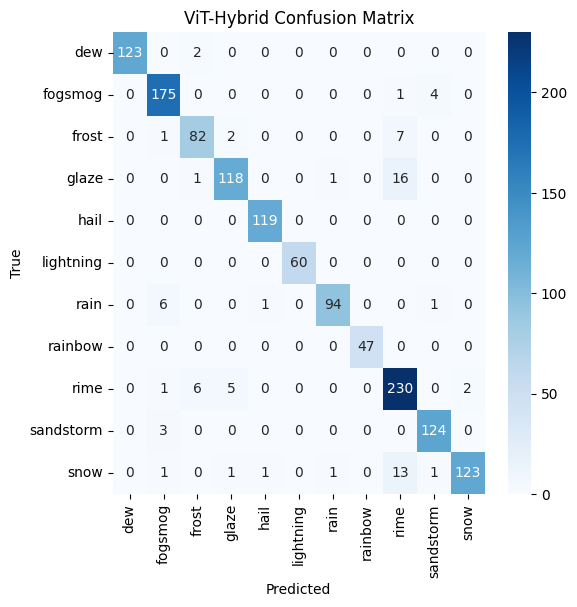

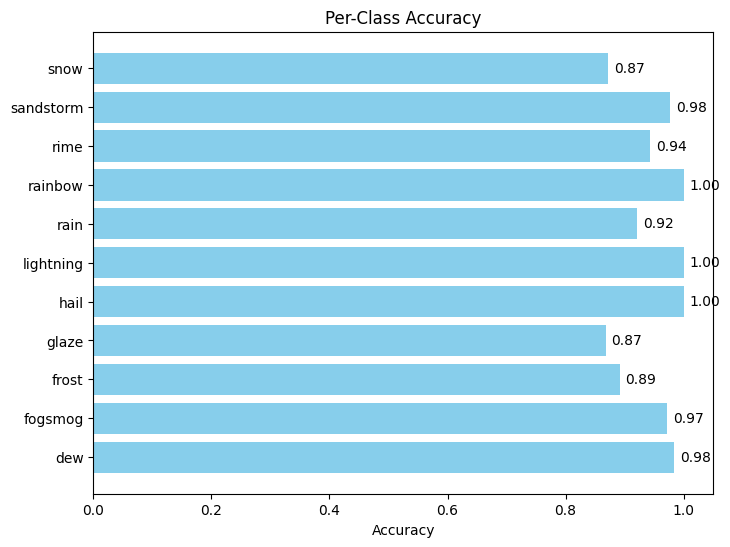

Visual Predictions from ViT-Hybrid:


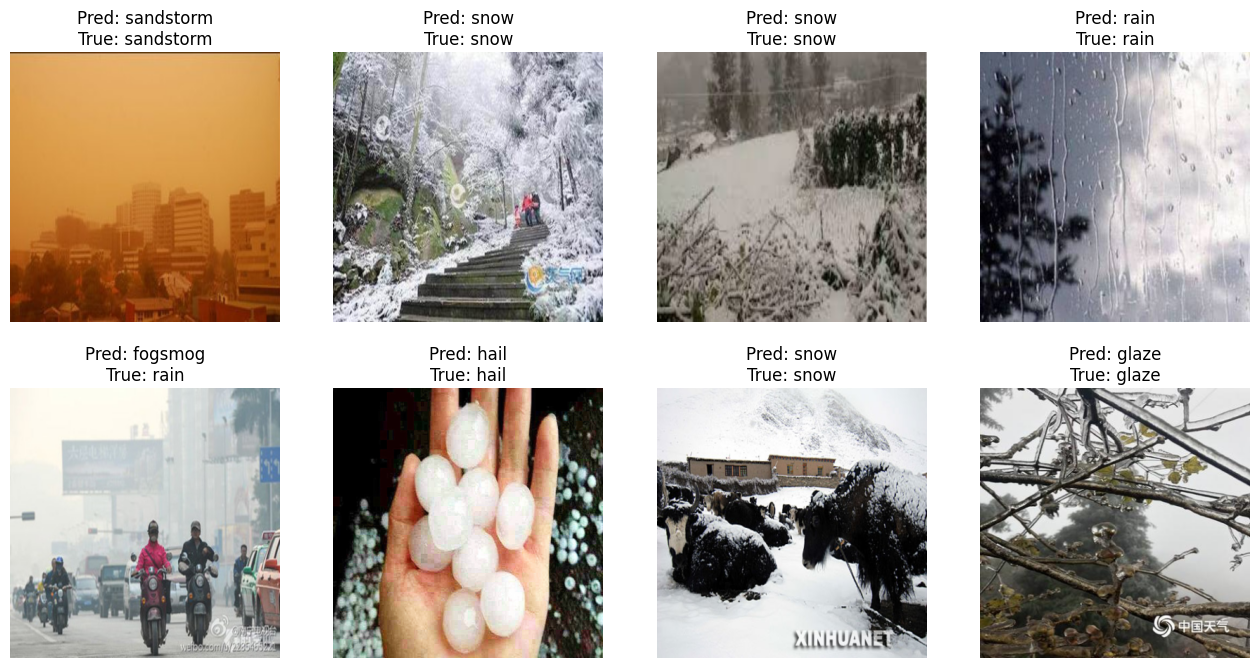

In [ ]:
image_processor_hybrid = ViTHybridImageProcessor.from_pretrained('google/vit-hybrid-base-bit-384')
train_dataset_hybrid = train_dataset.with_transform(get_transform_fns(train_augmentation_hybrid, image_processor_hybrid))
val_dataset_hybrid = val_dataset.with_transform(get_transform_fns(val_test_augmentation_hybrid, image_processor_hybrid))
test_dataset_hybrid = test_dataset.with_transform(get_transform_fns(val_test_augmentation_hybrid, image_processor_hybrid))

train_loader_hybrid = DataLoader(train_dataset_hybrid, batch_size=BATCH_SIZE, sampler=sampler, collate_fn=collate_fn)
val_loader_hybrid = DataLoader(val_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader_hybrid = DataLoader(test_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

vit_hybrid_base = ViTHybridModel.from_pretrained("google/vit-hybrid-base-bit-384")
vit_hybrid_model = ViTForWeatherClassification(vit_hybrid_base, num_classes=num_classes, class_weights=class_weights_tensor)

print("\nTraining ViT-Hybrid Model:")
vit_hybrid_trained, vit_hybrid_history = train_model(vit_hybrid_model, train_loader_hybrid, val_loader_hybrid,
                                                     epochs=EPOCHS, lr=LEARNING_RATE,
                                                     use_mixup=USE_MIXUP, mixup_alpha=MIXUP_ALPHA)
plot_curves(vit_hybrid_history, title_prefix="ViT-Hybrid")

print("\nEvaluating ViT-Hybrid on Test Set:")
hybrid_acc, hybrid_preds, hybrid_labels = evaluate(vit_hybrid_trained, test_loader_hybrid)
print(f"Test Accuracy: {hybrid_acc:.4f}")
print(classification_report(hybrid_labels, hybrid_preds, target_names=class_names))
f1_macro_h = f1_score(hybrid_labels, hybrid_preds, average='macro')
f1_micro_h = f1_score(hybrid_labels, hybrid_preds, average='micro')
print(f"ViT-Hybrid Macro-F1: {f1_macro_h:.4f}, Micro-F1: {f1_micro_h:.4f}")
plot_confusion_matrix(hybrid_labels, hybrid_preds, class_names, "ViT-Hybrid")
plot_per_class_accuracy(hybrid_labels, hybrid_preds, class_names)
print("Visual Predictions from ViT-Hybrid:")
show_predictions(vit_hybrid_trained, test_loader_hybrid, num_images=8, image_processor=image_processor_hybrid, class_names=class_names)

#18. Comparison Plots Between ViT and ViT-Hybrid

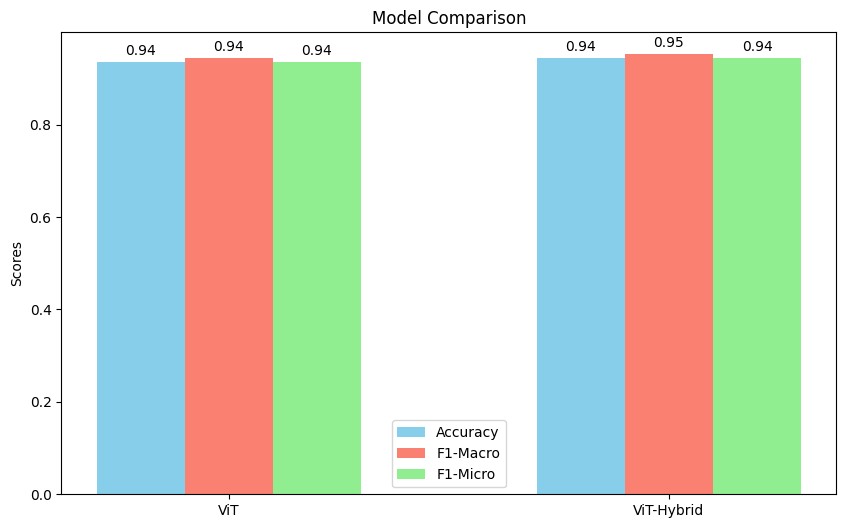

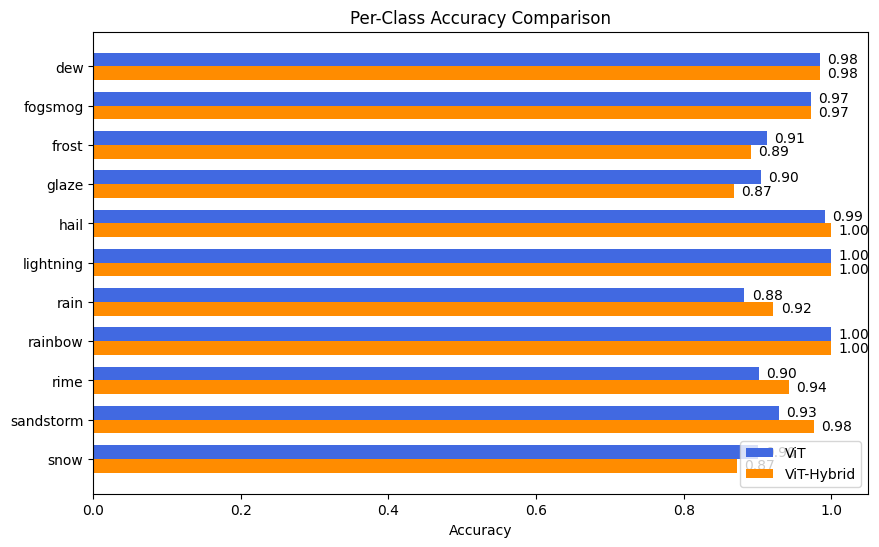

In [ ]:
models = ['ViT', 'ViT-Hybrid']
accuracies = [vit_acc, hybrid_acc]
f1_macros = [f1_macro, f1_macro_h]
f1_micros = [f1_micro, f1_micro_h]

def plot_comparison(models, accuracies, f1_macros, f1_micros):
    x = np.arange(len(models))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10,6))

    acc_bars = ax.bar(x - width, accuracies, width, label='Accuracy', color='skyblue')
    macro_bars = ax.bar(x, f1_macros, width, label='F1-Macro', color='salmon')
    micro_bars = ax.bar(x + width, f1_micros, width, label='F1-Micro', color='lightgreen')

    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()


    def annotate_bars(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0,3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    annotate_bars(acc_bars)
    annotate_bars(macro_bars)
    annotate_bars(micro_bars)

    plt.show()

plot_comparison(models, accuracies, f1_macros, f1_micros)

# Compare per-class accuracies side by side
vit_cm = confusion_matrix(vit_labels, vit_preds)
vit_per_class_acc = vit_cm.diagonal() / vit_cm.sum(axis=1)

hybrid_cm = confusion_matrix(hybrid_labels, hybrid_preds)
hybrid_per_class_acc = hybrid_cm.diagonal() / hybrid_cm.sum(axis=1)

x = np.arange(len(class_names))
width = 0.35

plt.figure(figsize=(10,6))
vit_bars = plt.barh(x - width/2, vit_per_class_acc, width, label='ViT', color='royalblue')
hybrid_bars = plt.barh(x + width/2, hybrid_per_class_acc, width, label='ViT-Hybrid', color='darkorange')

plt.xlabel("Accuracy")
plt.title("Per-Class Accuracy Comparison")
plt.yticks(x, class_names)
plt.legend()
plt.gca().invert_yaxis()

def annotate_bars_horizontal(bars):
    for bar in bars:
        w = bar.get_width()
        plt.text(w + 0.01, bar.get_y() + bar.get_height()/2, f"{w:.2f}", va='center')

annotate_bars_horizontal(vit_bars)
annotate_bars_horizontal(hybrid_bars)

plt.show()
